# Generative Algorithm

### Genetic Algorithm Principle Explanation

This genetic algorithm (GA) implements evolutionary optimization through selection, crossover, and mutation operations. The algorithm evolves a population of binary-encoded solutions over generations to maximize fitness.

#### 1. Chromosome Representation

Each individual is represented as a binary vector:

$
\mathbf{v} = [v_1, v_2, ..., v_{n}], \quad v_i \in \{0,1\}
$

where $n$ is the number of genes (`num_genes`).

#### 2. Population Initialization

The initial population of size $P$ (`pop_size`) is generated:

$$
P^{(0)} = \{\mathbf{v}_1, \mathbf{v}_2, ..., \mathbf{v}_P\}, \quad \mathbf{v}_i \sim \mathcal{U}\{0,1\}^n
$$

#### 3. Fitness Evaluation

The fitness function (to be implemented) evaluates solution quality:

$$
f(\mathbf{v}) = \text{fitness}(\text{decoder}(\mathbf{v}))
$$

The decoder converts the binary vector to problem-specific parameters.

#### 4. Selection Mechanism

A softmax-weighted roulette wheel selection is used:

$$
P(\mathbf{v}_i) = \frac{e^{f(\mathbf{v}_i)}}{\sum_{j=1}^P e^{f(\mathbf{v}_j)}}
$$

Cumulative probabilities are calculated for selection:

$$
C_k = \sum_{i=1}^k P(\mathbf{v}_i), \quad k = 1,2,...,P
$$

#### 5. Crossover Operation

Single-point crossover with probability $p_c$ (`cross_rate`):

$$
\mathbf{v}_1' = [\mathbf{v}_1^{1:r} \Vert \mathbf{v}_2^{r+1:n}]
$$
$$
\mathbf{v}_2' = [\mathbf{v}_2^{1:r} \Vert \mathbf{v}_1^{r+1:n}]
$$

where $r$ is a random crossover point: $r ∼ \mathcal{U}_{1,2,...,n-1}$

#### 6. Mutation Operation

Bit-flip mutation with probability $p_m$ (`mutation_rate`):

$$
v_i' = \begin{cases}
1 - v_i & \text{with probability } p_m \\
v_i & \text{otherwise}
\end{cases}
$$

#### 7. Generational Transition

The algorithm implements elitism through:

$$
P^{(t+1)} = \text{sort}\left(\{\mathbf{v}_1', ..., \mathbf{v}_P'\} \cup \mathbf{v}_{\text{best}}^{(t)}, f \right)
$$

where $v_{best}$ is the best solution from previous generation.

### Algorithmic Flow

1. **Initialization**: Generate initial population
2. **Iterative Evolution**:
   - **Selection**: Choose parents using softmax probabilities
   - **Crossover**: Recombine parent chromosomes
   - **Mutation**: Perturb offspring chromosomes
   - **Evaluation**: Calculate fitness for new population
   - **Elitism**: Preserve best solution across generations
3. **Termination**: After `max_iter` generations, return best solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class GA:
    def __init__(self, seed=0, pop_size=100, num_genes=20, mutation_rate=0, cross_rate=0, max_iter=100):
        self.pop_size = pop_size
        self.num_genes = num_genes
        self.mutation_rate = mutation_rate
        self.cross_rate = cross_rate
        self.max_iter = max_iter

        np.random.seed(seed=seed)


    def create_one_individual(self):
        return np.random.randint(0, 2, self.num_genes)

    def init(self):
        pop = [self.create_one_individual() for _ in range(self.pop_size)]
        return pop
    
    def fitness(self):
        pass

    def decoder(self, v):
        return (v, )

    def __call__(self):
        pop = self.init()

        fitl = []
        best_keep = []

        for _ in range(self.max_iter):
            ppop = []

            self.selection(pop)  # init self.pl

            for _ in range(self.pop_size):
                v = self.selection(pop, mute=False)
                ppop.append(v)

            pop = ppop
            ppop = []
            self.selection(pop)  # init self.pl
            for _ in range(self.pop_size // 2):
                r = np.random.random()

                v1 = self.selection(pop, mute=False)
                v2 = self.selection(pop, mute=False)
                if r < self.cross_rate:
                    vv1, vv2 = self.crossover(v1, v2)
                    ppop.append(vv1)
                    ppop.append(vv2)
                else:
                    ppop.append(v1)
                    ppop.append(v2)

            if self.pop_size % 2:
                ppop.append(self.selection(pop, mute=False))  # if pop_size is odd, the last one will not be mutated

            for v in ppop:  # mutate
                v = self.mutate(v)

            pop = ppop
            pop = sorted(pop, key=lambda v: self.fitness(*self.decoder(v)), reverse=True)  # sort

            vbest = pop[0]  # get the best in one generation
            fbest = self.fitness(*self.decoder(vbest))
            best_keep.append(vbest)

            fitl.append(fbest)

        pop = best_keep
        pop = sorted(pop, key=lambda v: self.fitness(*self.decoder(v)), reverse=True)  # sort

        vbest = pop[0]  # get the best in all generations

        return vbest, fitl

    def selection(self, pop, mute=True):
        if mute:
            fl = []
            for v in pop:
                f = self.fitness(*self.decoder(v))
                fl.append(f)

            fl = np.array(fl)
            fl = np.exp(fl)
            fl = fl / np.sum(fl)  # softmax

            self.pl = [np.sum(fl[:i]) for i in range(len(fl))]

        r = np.random.random()
        for i in range(len(self.pl)):
            if self.pl[i] > r:
                return pop[i]
        
        return pop[-1]
                    
    def crossover(self, v1, v2):
        r = np.random.randint(0, self.num_genes)
        vv1 = np.zeros(self.num_genes)
        vv2 = np.zeros(self.num_genes)

        vv1[:r] = v1[:r]
        vv1[r:] = v2[r:]

        vv2[:r] = v2[:r]
        vv2[r:] = v1[r:]

        return vv1, vv2

    def mutate(self, v):
        for i in range(self.num_genes):
            if np.random.random() < self.mutation_rate:
                v[i] = 1 - v[i]

        return v


## # Case1 

Solve Equation: 

$$
X\cdot \cos(2\pi Y) + Y\cdot \sin(2\pi X) = 0
$$

### **Encoding and Decoding**

1. **Binary Chromosome**:

   - Each individual is a binary vector:  

     $$
     \mathbf{v} = [v_1, v_2, ..., v_n], \quad v_i \in \{0,1\}
     $$

2. **Split Chromosome**:

   - Split into two halves:  

     $$
     \text{decx} = [v_1, v_2, ..., v_{n/2}], \quad \text{decy} = [v_{n/2+1}, v_{n/2+2}, ..., v_n]
     $$

3. **Binary to Decimal**:

   - Convert binary to decimal:  

     $$
     x_{\text{decimal}} = \sum_{i=0}^{n/2-1} \text{decx}_i \cdot 2^i
     $$

     $$
     y_{\text{decimal}} = \sum_{i=0}^{n/2-1} \text{decy}_i \cdot 2^i
     $$

4. **Scale to [-2, 2]**:

   - Scale to the range $[-2, 2]$:  

     $$
     x = \frac{(x_{\text{decimal}} - dx)}{dx} \cdot 2, \quad dx = 2^{(n/2 - 1)}
     $$

     $$
     y = \frac{(y_{\text{decimal}} - dy)}{dy} \cdot 2, \quad dy = 2^{(n/2 - 1)}
     $$


### **Fitness Function**

The fitness function is:  

$$
f(x, y) = x \cdot \cos(2\pi y) + y \cdot \sin(2\pi x)
$$

In [3]:
class GA1(GA):
    def __init__(self, seed=0, pop_size=100, num_genes=20, mutation_rate=0, cross_rate=0, max_iter=100):
        super().__init__(seed, pop_size, num_genes, mutation_rate, cross_rate, max_iter)

    def create_one_individual(self):
        return np.random.randint(0, 2, self.num_genes)
    
    def decoder(self, v):
        decx = v[0:len(v)//2]
        decy = v[len(v)//2:]

        # decx = []
        # decy = []
        # for i in range(len(v)):
        #     if i%2 == 0:
        #         decx.append(v[i])
        #     else:
        #         decy.append(v[i])
                
        x = np.dot(np.array([2**i for i in range(len(decx))]), decx)
        y = np.dot(np.array([2**i for i in range(len(decy))]), decy)

        # scale to [-2, 2]
        dx = 2**(len(decx) - 1)
        x = (x - dx) / (dx) * 2
        dy = 2**(len(decy) - 1)
        y = (y - dy) / (dy) * 2
        return x, y

    def fitness(self, X, Y):
        return X*np.cos(2*np.pi*Y) + Y*np.sin(2*np.pi*X)

[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1.76171875, -2.0)
3.7562996633573804
3.7563359221353894


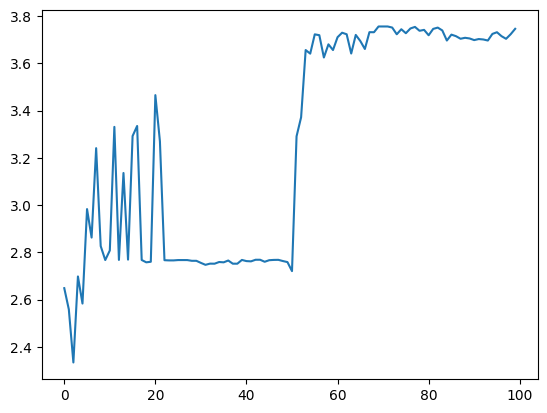

In [4]:
GAr = None

vb = None
vf = None
cost = -np.inf
for _ in range(10):
    # GAr = GA1(seed=np.random.randint(0, 100000), pop_size=500, mutation_rate=0.05, cross_rate=0.7, max_iter=100, num_genes=25)
    GAr = GA1(seed=np.random.randint(0, 100000), pop_size=100, mutation_rate=0.05, cross_rate=0.7, max_iter=100, num_genes=20)
    vbest, fitl = GAr()
    ccost = GAr.fitness(*GAr.decoder(vbest))

    if ccost > cost:
        vb = vbest
        vf = fitl
        cost = ccost

print(vb)
print(GAr.decoder(vb))
print(cost)
print(f'{GAr.fitness(1.76267854, -2)}')
plt.plot(range(len(vf)), vf)
plt.show()

## Case2: Traveling Salesman Problem

In [5]:
x = [ 116.46 ,117.2 ,121.48 ,106.54 ,91.11 ,87.98 ,106.27 ,111.65 ,108.33 ,126.63 ]
y = [ 39.92 ,39.13 ,31.22 ,29.59 ,29.97 ,43.77 ,38.47 ,40.82 ,22.84 ,45.75 ] 
dist = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D', 
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J'
}

DIS = [[0 for _ in range(len(x))] for _ in range(len(x))]

for i in range(len(x)):
    for j in range(len(x)):
       DIS[i][j] = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)

In [6]:
class GA2(GA):
    def __init__(self, seed=0, pop_size=100, num_genes=20, mutation_rate=0, cross_rate=0, max_iter=100):
        super().__init__(seed, pop_size, num_genes, mutation_rate, cross_rate, max_iter)

    def decoder(self, v):
        return (v, )  # return a tuple is must here

    def fitness(self, v):
        sum = 0
        for i in range(-1, self.num_genes - 1):
            sum += DIS[int(v[i])][int(v[i + 1])]

        sum /= 1e4
        return -sum

    def create_one_individual(self):
        return np.random.permutation(self.num_genes)

    def crossover(self, v1, v2):
        r = np.random.randint(0, self.num_genes)
        vv1 = np.zeros(self.num_genes)
        vv2 = np.zeros(self.num_genes)

        vv1[:r] = v1[:r]
        rr = r
        for x in v2:
            if x not in vv1:
                vv1[rr] = x
                rr += 1
                if rr == self.num_genes:
                    break

        vv2[:r] = v2[:r]
        rr = r
        for x in v1:
            if x not in vv2:
                vv2[rr] = x
                rr += 1
                if rr == self.num_genes:
                    break

        return vv1, vv2

    def mutate(self, v):
        for i in range(self.num_genes):
            if np.random.random() < self.mutation_rate:
                j = np.random.randint(0, self.num_genes)
                v[i], v[j] = v[j], v[i]

[1. 9. 2. 8. 3. 4. 5. 6. 7. 0.]
109.98824625831298


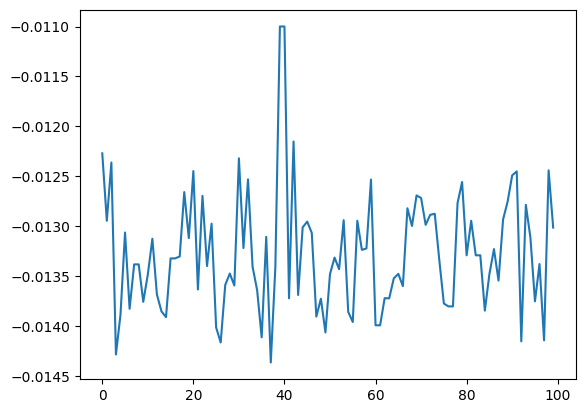

B -> J -> C -> I -> D -> E -> F -> G -> H -> A -> 

In [7]:
GAr = None

vb = None
vf = None
cost = -np.inf
for _ in range(10):
    GAr = GA2(seed=np.random.randint(0, 1e5), pop_size=300, mutation_rate=0.05, cross_rate=0.5, max_iter=100, num_genes=10)
    vbest, fitl = GAr()
    ccost = GAr.fitness(*GAr.decoder(vbest))

    if ccost > cost:
        vb = vbest
        vf = fitl
        cost = ccost

print(vb)
print(-cost*1e4)
plt.plot(range(len(vf)), vf)
plt.show()

for i in vb: 
    print(dist[i], end=' -> ')